In [1]:
import numpy as np
from scipy.optimize import root
from scipy import linalg as la
from scipy.integrate import odeint
from matplotlib import pyplot as plt

### Problem 1

In [2]:
g = 9.8
def linearized_init(M, m, l, q1, q2, q3, q4, r):
    '''
    Parameters:
    ----------
    M, m: floats
          masses of the rickshaw and the present
    l   : float
          length of the rod
    q1, q2, q3, q4, r : floats
    relative weights of the position and velocity of the rickshaw, ←  the
    angular displacement theta and the change in theta, and the ←  control
    Return
    -------
    A : ndarray of shape (4,4)
    B : ndarray of shape (4,1)
    Q : ndarray of shape (4,4)
    R : ndarray of shape (1,1)
    '''
    A = np.zeros((4,4))
    A[0,1],A[2,-1],A[1,2],A[-1,2] = 1,1,m*g/M,g/(M*l)*(M+m)
    B = np.zeros((4,1))
    B[1,0],B[-1,0] = 1/M,1/(M*l)
    Q = np.zeros((4,4))
    np.fill_diagonal(Q,[q1,q2,q3,q4])
    R = np.array(r)
    return A,B,Q,R

In [3]:
def find_P(A, B, Q, R):
    '''
    Parameters:
    ----------
    A, Q    : ndarrays of shape (4,4)
    B       : ndarray of shape (4,1)
    R       : ndarray of shape (1,1)
    Returns
    -------
    P       : the matrix solution of the Riccati equation
    '''
    guess = np.array([1]*16)
    def func(P) :
        P = P.reshape((4,4))
        new = P.dot(A) + A.T.dot(P) + Q - np.dot(P.dot(B),B.T.dot(P))/R
        return new.reshape(16)
    sol = root(func,guess)['x']
    return sol.reshape((4,4))

In [4]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
A,B,Q,R = linearized_init(M,m,l,q1,q2,q3,q4,r)
P = find_P(A,B,Q,R)
val = A - np.dot(B.dot(B.T),P)/R
eig_vals, eig_vects = la.eig(val)
print(eig_vals)
print(eig_vects[:,-1])

[-1.72875212+0.j         -0.07538846+0.07490226j -0.07538846-0.07490226j
  1.72530814+0.j        ]
[ 0.28969567+0.j  0.49981430+0.j  0.40931888+0.j  0.70620120+0.j]


One eigenvalue is positive and greater than one, and it's eigenvector is not zero, so we won't have $\tilde{z} \rightarrow 0$.

In [5]:
def rickshaw(tv, X0, A, B, Q, R, P):
    '''
    Parameters:
    ----------
    tv  : ndarray of time values, with shape (n+1,)
    X0  : Initial conditions on state variables
    A, Q: ndarrays of shape (4,4)
    B   : ndarray of shape (4,1)
    R   : ndarray of shape (1,1)
    P   : ndarray of shape (4,4)
    Returns
    -------
    Z : ndarray of shape (n+1,4), the state vector at each time
    U : ndarray of shape (n+1,), the control values
    '''
    n = tv.shape[0]
    coeff = A - np.dot(B.dot(B.T),P)/R
    def diff(z,t) :
        return np.dot(coeff,z)
    Z = odeint(func=diff,y0=X0,t=tv)
    U = np.zeros(n)
    for i in range(n) :
        U[i] = -np.dot(B.T,P).dot(Z[i,:])/R
    return Z,U

In [6]:
tf1 = 6
tf2 = 60
tv1 = np.linspace(0,tf1,100)
tv2 = np.linspace(0,tf2,100)
X0 = np.array([-1,-1,-.1,-.2])
Z1,U1 = rickshaw(tv1,X0,A,B,Q,R,P)
Z2,U2 = rickshaw(tv2,X0,A,B,Q,R,P)

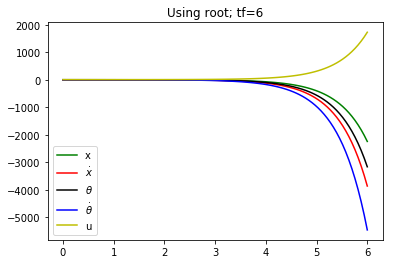

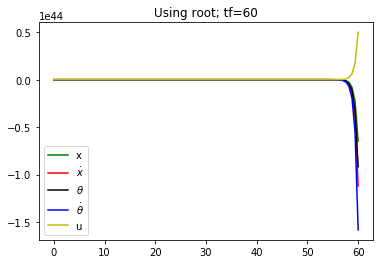

In [7]:
plt.plot(tv1,Z1[:,0],'g',label='x')
plt.plot(tv1,Z1[:,1],'r',label='$\dot{x}$')
plt.plot(tv1,Z1[:,2],'k',label='$\\theta$')
plt.plot(tv1,Z1[:,3],'b',label='$\dot{\\theta}$')
plt.plot(tv1,U1,'y',label='u')
plt.legend()
plt.title('Using root; tf=6')
plt.show()
plt.plot(tv2,Z2[:,0],'g',label='x')
plt.plot(tv2,Z2[:,1],'r',label='$\dot{x}$')
plt.plot(tv2,Z2[:,2],'k',label='$\\theta$')
plt.plot(tv2,Z2[:,3],'b',label='$\dot{\\theta}$')
plt.plot(tv2,U2,'y',label='u')
plt.title('Using root; tf=60')
plt.legend()
plt.show()

In [8]:
P1 = la.solve_continuous_are(A,B,Q,R)
Z1,U1 = rickshaw(tv1,X0,A,B,Q,R,P1)
Z2,U2 = rickshaw(tv2,X0,A,B,Q,R,P1)

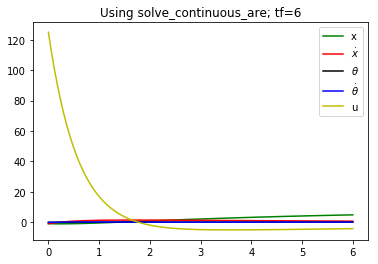

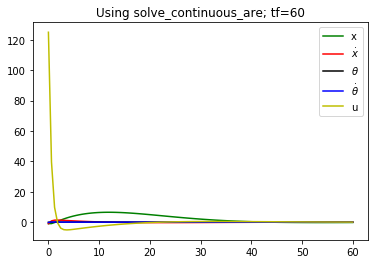

In [9]:
plt.plot(tv1,Z1[:,0],'g',label='x')
plt.plot(tv1,Z1[:,1],'r',label='$\dot{x}$')
plt.plot(tv1,Z1[:,2],'k',label='$\\theta$')
plt.plot(tv1,Z1[:,3],'b',label='$\dot{\\theta}$')
plt.plot(tv1,U1,'y',label='u')
plt.legend()
plt.title('Using solve_continuous_are; tf=6')
plt.show()
plt.plot(tv2,Z2[:,0],'g',label='x')
plt.plot(tv2,Z2[:,1],'r',label='$\dot{x}$')
plt.plot(tv2,Z2[:,2],'k',label='$\\theta$')
plt.plot(tv2,Z2[:,3],'b',label='$\dot{\\theta}$')
plt.plot(tv2,U2,'y',label='u')
plt.title('Using solve_continuous_are; tf=60')
plt.legend()
plt.show()